In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,Dense,Conv2DTranspose,AveragePooling2D,BatchNormalization,LeakyReLU,Reshape,Dropout,Flatten
import sklearn
import datetime
from sklearn.datasets import load_files
import matplotlib.pyplot as plt
import numpy as np
from io import BytesIO
import pickle
from tensorflow.summary import SummaryWriter
%load_ext tensorboard
from PIL import Image  

In [0]:
pickle_train = "/content/drive/My Drive/Dataset/DL-Assign 2/data.pickle"

pickle_in = open(pickle_train,'rb')
data = pickle.load(pickle_in)

In [0]:
BUFFER_SIZE = 30000
BATCH_SIZE = 128

data = (data - 127.5) / 127.5
train_dataset = tf.data.Dataset.from_tensor_slices(data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [0]:
def generator_builder():
    model = tf.keras.Sequential()
    model.add(Dense(8*8*512,use_bias=False,input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Reshape((8,8,512)))
    assert model.output_shape == (None, 8, 8, 512)

    model.add(Conv2DTranspose(256,(5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 256)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(32, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 32)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 3)

    return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32768)             3276800   
_________________________________________________________________
batch_normalization (BatchNo (None, 32768)             131072    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32768)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 256)       3276800   
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 256)       1024      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 256)       0

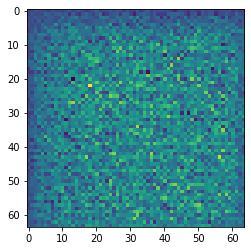

In [8]:
generator = generator_builder()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])
generator.summary()

In [0]:
def discriminator_builder():
    model = tf.keras.Sequential()
    model.add(Conv2D(64,(5,5),strides=(2,2),padding='same',name="TER",input_shape=[64,64,3]))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128,(5,5),strides=(2,2),padding='same',name="2"))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.2))
    
    model.add(Conv2D(256,(5,5),strides=(2,2),padding='same',name="3"))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.2))

    model.add(Conv2D(512,(5,5),strides=(2,2),padding='same',name="4"))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(1))

    return model

In [10]:
discriminator = discriminator_builder()
decision = discriminator(generated_image)
print (decision)

discriminator.summary()

tf.Tensor([[-0.0002206]], shape=(1, 1), dtype=float32)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
TER (Conv2D)                 (None, 32, 32, 64)        4864      
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
2 (Conv2D)                   (None, 16, 16, 128)       204928    
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________

In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [0]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [0]:
generator_loss_hist = tf.keras.metrics.Mean('gen_loss', dtype=tf.float32)
discriminator_loss_hist = tf.keras.metrics.Mean('disc_loss', dtype=tf.float32)

In [0]:
epochs = 200
noise_dim = 100
num_examples = 36

seed = tf.random.normal([num_examples, noise_dim])

In [0]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

      generator_loss_hist(gen_loss)
      discriminator_loss_hist(disc_loss)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [0]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H-%M-%S")
gan_log_dir = 'logs/gradient_tape/' + current_time + '/gan'
#disc_log_dir = 'logs/gradient_tape/' + current_time + '/disc'
GAN_summary_writer = tf.summary.create_file_writer(gan_log_dir)
#disc_summary_writer = tf.summary.create_file_writer(disc_log_dir)


In [0]:
listy_gen = []
listy_disc = []
def train(dataset, epochs):
    for epoch in range(epochs):
    #start = time.time()

        print(epoch)
        for image_batch in dataset:
            train_step(image_batch)
    
        listy_gen.append(generator_loss_hist.result())
        listy_disc.append(discriminator_loss_hist.result())

        if epoch % 50 == 0:
            generate_and_save_images(generator,epoch,seed)

        generator_loss_hist.reset_states()
        discriminator_loss_hist.reset_states()

In [0]:
def generate_and_save_images(model, epoch, test_input):

  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(6,6))

  for i in range(predictions.shape[0]):
      plt.subplot(6, 6, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
      plt.axis('off')

  plt.savefig(f'image_at_epoch_{epoch}.png')
  plt.show()
  plt.close('all')
  plt.clf()

0


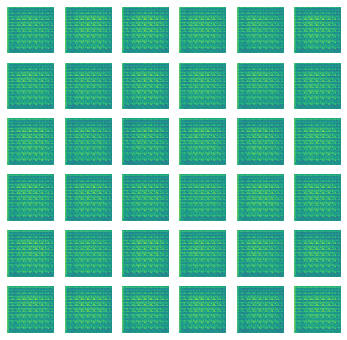

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


<Figure size 432x288 with 0 Axes>

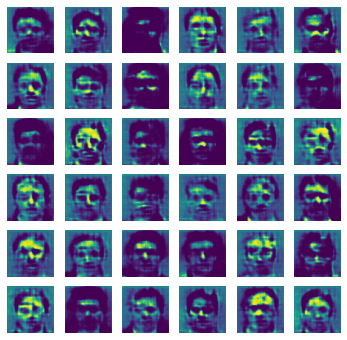

51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


<Figure size 432x288 with 0 Axes>

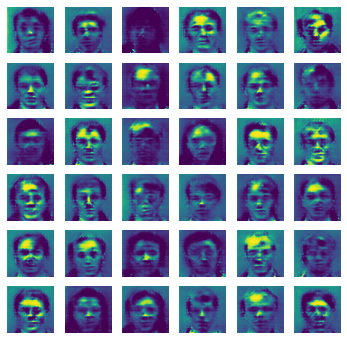

101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150


<Figure size 432x288 with 0 Axes>

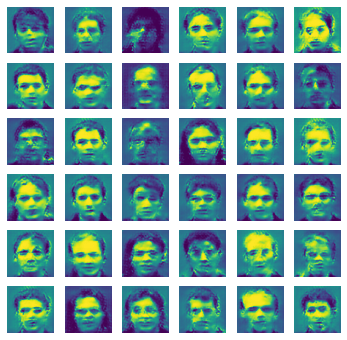

151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


<Figure size 432x288 with 0 Axes>

In [23]:
train(train_dataset, 200)

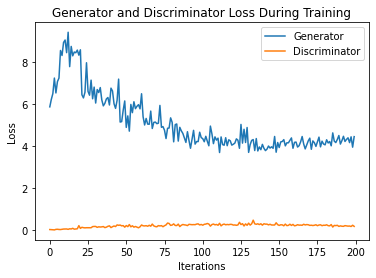

<Figure size 432x288 with 0 Axes>

In [24]:
plt.title("Generator and Discriminator Loss During Training")
plt.plot(listy_gen,label="Generator")
plt.plot(listy_disc,label="Discriminator")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig('graph.png')
plt.show()
plt.close('all')
plt.clf()